## 세그멘테이션(Segmentation)
* 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
* 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 갖는다고 가정

### 시멘틱 세그멘테이션(semantic segmentation)
* 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션
* 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법
* 사람이 누구인지 관계없이 같은 라벨로 표현

### 인스턴스 세그멘테이션(Instance segmentation)
* 사람 개개인 별로 다른 라벨링
* 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하는 것이 목표

## 필요 라이브러리 및 메소드 불러오기

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 사용하고자 하는 이미지 불러오기

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/selfie.jpg'
img_hm = cv2.imread(img_path) 
print(img_hm.shape)

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.jpg'
img_dog = cv2.imread(img_path) 
print(img_dog.shape)

(339, 509, 3)
(400, 700, 3)


## DeepLabModel 불러오기

### preprocess() : 전처리 함수
* input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리
* resize
* OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정

### run() : 실제로 세그멘테이션을 하는 함수

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

## 학습된 가중치 다운(transfer learning)
* 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 받고 DeepLabModel 을 초기화

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj62/aiffel/human_segmentation/models
model loaded successfully!


## 데이터 리사이징

In [5]:
hm_resized, hmseg_map = MODEL.run(img_hm)
print (img_hm.shape, hm_resized.shape, hmseg_map.max())

dog_resized, dogseg_map = MODEL.run(img_dog)
print (img_dog.shape, dog_resized.shape, dogseg_map.max())

(339, 509, 3) (341, 513, 3) 15
(400, 700, 3) (293, 513, 3) 16


### 이미지 모양, 정보 확인

In [6]:
print(hmseg_map.shape)
print (img_hm.shape, hm_resized.shape, hmseg_map[200])

(341, 513)
(339, 509, 3) (341, 513, 3) [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0

## 라벨네임 확인
* 원하는 대상을 추출할때 인덱스로 사용

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

## 배경과 대상 분리

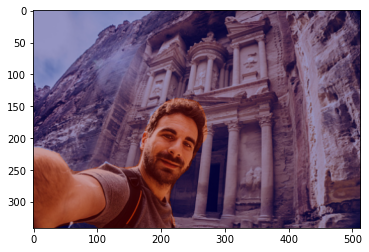

In [8]:
hm_show = hm_resized.copy()
seg_map = np.where(hmseg_map == 15, 15, 0) # 예측 중 사람만 추출 (if 15, 15, else 0)
hm_mask = seg_map * (255/hmseg_map.max()) # 255 (Min-Max)normalization
hm_mask = hm_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(hm_mask, cv2.COLORMAP_JET)

#두 이미지의 명암조정
hm_show = cv2.addWeighted(hm_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(hm_show, cv2.COLOR_BGR2RGB))
plt.show()

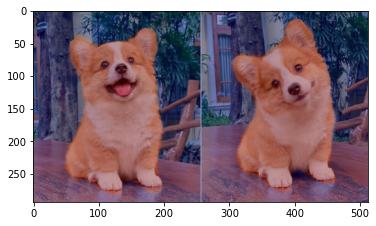

In [9]:
dog_show = dog_resized.copy()
dogseg_map = np.where(dogseg_map == 12, 12, 0) # 예측 중 사람만 추출
dog_mask = dogseg_map * (255/dogseg_map.max()) # 255 normalization
dog_mask = dog_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(dog_mask, cv2.COLORMAP_JET)
dog_show = cv2.addWeighted(dog_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(dog_show, cv2.COLOR_BGR2RGB))
plt.show()

## 처리 데이터 복원
### cv2.resize() 함수를 이용

* 크기를 키울 때 보간(interpolation) 을 고려
* 보간법(interpolation) : 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
* cv2.INTER_LINEAR 를 사용

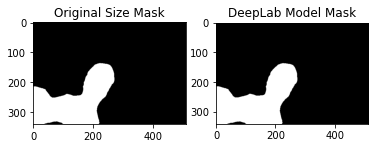

In [10]:
hm_mask_up = cv2.resize(hm_mask, img_hm.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, hm_mask_up = cv2.threshold(hm_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(hm_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(hm_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

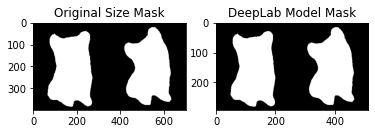

In [11]:
dog_mask_up = cv2.resize(dog_mask, img_dog.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, dog_mask_up = cv2.threshold(dog_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(dog_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(dog_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 배경 흐리게 하기
### 배경을 흐리게 하기 위해 배경 추출

* bitwise_not 함수를 이용하면 이미지 반전(배경: 255, 사람 : 0)

* 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상 획득

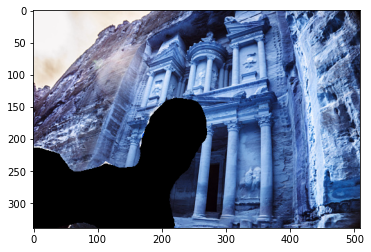

In [12]:
hm_mask_color = cv2.cvtColor(hm_mask_up, cv2.COLOR_GRAY2BGR)
hm_bg_mask = cv2.bitwise_not(hm_mask_color)
hm_bg = cv2.bitwise_and(img_hm, hm_bg_mask)
plt.imshow(hm_bg)
plt.show()

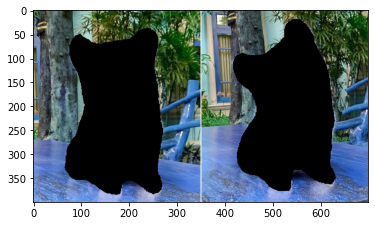

In [13]:
dog_mask_color = cv2.cvtColor(dog_mask_up, cv2.COLOR_GRAY2BGR)
dog_bg_mask = cv2.bitwise_not(dog_mask_color)
dog_bg = cv2.bitwise_and(img_dog, dog_bg_mask)
plt.imshow(dog_bg)
plt.show()

### 블러(blur)처리하여 배경이 흐리게 처리된 이미지 획득

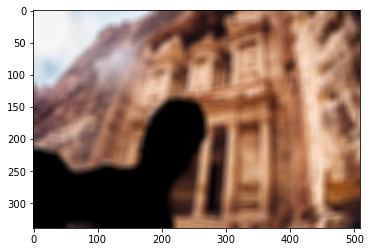

In [14]:
hm_bg_blur = cv2.blur(hm_bg, (13,13))
plt.imshow(cv2.cvtColor(hm_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

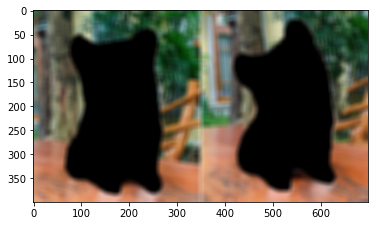

In [15]:
dog_bg_blur = cv2.blur(dog_bg, (13,13))
plt.imshow(cv2.cvtColor(dog_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 흐린 배경과 원본 영상 합성
### 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용

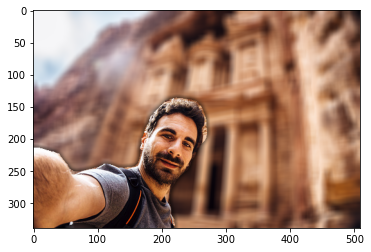

In [16]:
img_concat = np.where(hm_mask_color==255, img_hm, hm_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

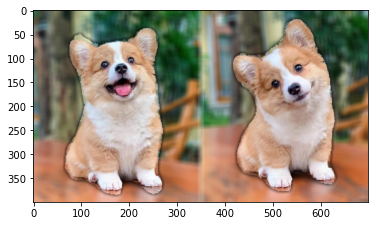

In [17]:
dog_concat = np.where(dog_mask_color==255, img_dog, dog_bg_blur)
plt.imshow(cv2.cvtColor(dog_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 위 강아지 마스크를 사용하여 배경합성

### 이미지 불러오기

In [18]:
bg_path = os.getenv("HOME")+("/aiffel/human_segmentation/images/bg.jpg")
img_bg = cv2.imread(bg_path)
print(img_bg.shape)
print(img_dog.shape)


(450, 800, 3)
(400, 700, 3)


In [19]:
img_bg.shape

(450, 800, 3)

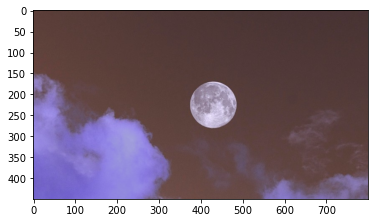

In [20]:
plt.imshow(img_bg)

### 이미지 크기 맞추기

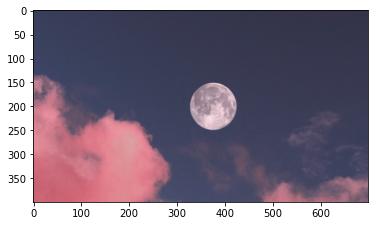

In [21]:
img_bg = cv2.resize(img_bg, dsize=(700, 400), interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

### 합성하기

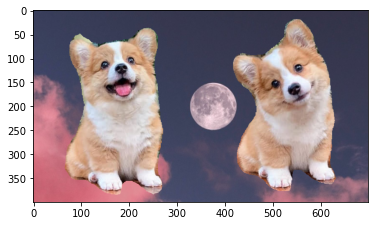

In [22]:
img_concat = np.where(dog_mask_color==255, img_dog, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### Step 1. 인물모드 직접 해 보기

인물 사진을 활용하여 인물모드 효과를 구현하였습니다. 또 강아지 사진을 배경사진과 합성하여 보름달이 뜬 밤 무서운 늑대의 모습을 구현하였습니다.

#### Step 2. 사진에서 문제점 찾기
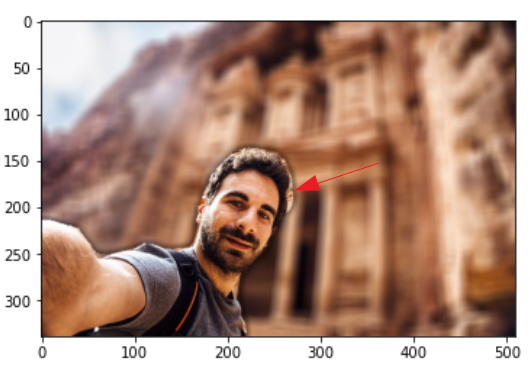
인물사진의 경우 인물만 완벽하게 추출하지 못해 약간의 부자연스러운 부분이 남아 있습니다. 인물과 배경의 색이 비슷해서 그런가 싶었는데 또 강아지 사진의 경우는 잔디밭 위의 강아지였기 때문에 완벽히 다른 색과 형태를 가지고 있었는데도 불구하고 분리가 완벽하게 이루어지지 않아 다소 어색한 부분이 남아있습니다. 이번 노드에선 모델의 동작 방식보단 구현에 초점을 두어 왜 저렇게 인식을 실패하는지 알 수 없었지만, 간편한 구현에 비해 기대 이상의 성능을 보임을 알 수 있었습니다.

#### Step 3. 해결 방법을 제안해 보기
 참고하라고 올려주신 여러 링크를 살펴보았지만, 대부분의 방법이 카메라를 두개 사용하거나, 적외선 카메라를 이용하는 등의 방식을 설명하고 있습니다. 그러나 우리가 구현하고자 하는 것은 일단 하나의 이미지를 보다 잘 인식하는 방안입니다. 
 
 제가 생각한 문제점은 대상을 제대로 인식하지 못해서 잘못된 영역까지 포함한다는 것이었습니다. 그래서 저는 우리의 모델이 학습을 어떤식으로 했는지는 모르지만, 학습 방법을 이런식으로 하면 좋지 않을까 하는 방식으로 제안해보려 합니다. 이제까지 공부한 내용 중 이미지 인식에 많이 사용되는 CNN을 도입하고 다음과 같은 방식을 사용하면 보다 정확한 추출이 가능하지 않을까 싶습니다.

 * CNN은 이미지를 학습하는데 이미지의 정보를 축소해 나가며 특징을 추출하는 특징이 있습니다. 이는 이미지를 학습하여 대상을 인식하고 클래스로 분류하는 데는 효과적이지만 사진 자체를 구성하는 위치 정보까지 손상될 수 있다는 단점이 있습니다. 
 이미지를 맥스풀링, 업샘플링하는 방식은 제가 단순하게 '특징을 추출하기 위해 스케일을 변형했다 복원하는 것'으로 이해했습니다. 그러나 이미지를 축소했다가 다시 복원하는것보다 좋은 방법은 축소를 하지 않는것이 아닐까 합니다. 
 이 문제를 해결하기 위해 패딩을 사용하여 이미지의 축소를 완화하면 좋을것 같습니다. (제가 기억하는 바로는 패딩은 정보의 왜곡과 이미지 축소를 완화합니다)
 
 
 * 또 필터를 작게만드는 방법이 있습니다. 필터의 크기에 따라 이미지가 축소되는 비중도 커지는데, 필터의 크기를 작게 만들고 깊게 쌓는다면, 정보의 손실은 줄이고 다양한 특징을 추출해 정확도를 높일 수 있을것 같습니다(극단적으로 필터를 F=1, S=1로 만들면 정보의 손실이 없이 다양한 특징을 뽑아낼 수 있습니다). 
 
 
 * 다만, 여기서 문제가 되는 연상량 증가부분은 추가적으로 얼마전 노드에도 나왔던 receptive field의 개념도 활용할 수 있을것 같습니다. 작은 필터가 놓칠 수 있는 부분은 이 개념을 활용하면 극심한 차원의 축소, 연산의 증가 없이도 특징을 잘 추출할 수 있는 것으로 기억합니다. 따라서 패딩으로 커버가 가능한 선에서 적절한 크기의 필터 사이즈를 활용하여 receptive field를 활용한다면 정보의 손실과 인식 성능사이의 타협점을 찾을 수 있을것 같습니다.

## 회고

### 어려웠던 부분
* 이번 노드는 기존의 모델과 가중치를 활용하여 구현하면서 어려운 점은 없었습니다. 그러나 다양한 개념들이 나오면서 여러 방면으로 생각해 봐야했으며, 이미지를 다양하게 변화시키는 부분이 다소 힘들었습니다. 또 10-4 부분의 DeepLabModel을 가져와 활용하는코드 부분은 이해가 어려웠습니다. 


### 아쉬운점
* 이번 노드에서 사용한 것은 시멘틱 세그멘테이션이었습니다. 제가 처음 시도했던 사진은 여러 사람이 있는 사진이었는데 여러 사람이 있는 경우 사람을 전부 인식하여 인물모드사진으로 구현할 수 없었습니다(사실 왜 포커싱이 안되는지도 나중에 노드를 다시 읽으면서 깨달았습니다.. 컨트롤키를 빼버려야하나..). 따라서 다음엔 인스턴스 세그멘테이션을 활용하여 원하는 사람에게만 인물모드를 적용하는 방법도 공부하면 좋을것 같습니다.

### 좋았던 점
* cv2.addWeighted메서드의 경우 이전 고양이 수염 노드에서 사용했었기 때문에 코드를 보고 이해하기 쉬웠습니다. 하나씩 배워가면 어떻게든 도움이 된다는 것을 다시한번 느낄 수 있었습니다.


* 마지막에 생각할 거리를 던져줬다는 점입니다. 사실 이제까지의 노드들이 '닥치고 따라해'라는 느낌이어서 하나하나 코드 복붙하기 바빴습니다. 그러다 처음으로 이런 질문이 던져져서 처음엔 어떤 방식으로 해결방안을 제시하라는것인지 이해하지 못했고, 그리고 엔지니어식 사고를 요구하는것 같아서 작성하지 않을 생각이었습니다.

 그러다 최근 노드와 CS231n에서 나온 개념들을 활용해 모델을 이런식으로 구성하면 되지 않을까 싶었고 요구사항과 거리가 있는것같지만 정리해보자는 생각이 들어서 주절주절 써보았습니다. 제가 제시한 방향은 요구한 방향과 핀트가 어긋났다고(그래서 좋은 답안은 아니라고) 생각하지만 '배웠던 내용을 이런식으로 접목시킬 수도 있겠구나' 라는 식의 사고를 할 수 있어 나름 즐거웠습니다.